In [137]:
%matplotlib notebook
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, roc_auc_score
import functools
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("Dark2")
sns.set_style("darkgrid")



os.chdir("/Users/andour/Google Drive/projects/Dissertation/Final data")

In [166]:
synthetic_dataset_freq = pickle.load(open( "simulated_data_freq", "rb" ))

In [170]:
synthetic_dataset_bayes = pickle.load(open( "simulated_data_bayes", "rb" ))
synthetic_dataset_bayes.columns

Index(['dataset', 'parameters', 'noise_bucket', 'label', 'drift', 'x_array',
       'y_array', 'logistic_evalutaion', 'logistic_param_estimation',
       'logistic_posterior_integral', 'linear_evalutaion',
       'linear_param_estimation', 'linear_posterior_integral',
       'bayes_classification', 'waic_classification'],
      dtype='object')

In [171]:
classification_sample_bayes = synthetic_dataset_bayes[["noise_bucket", "label", "drift", 
                                                       "bayes_classification", "waic_classification"]]

In [172]:
classification_sample_freq = synthetic_dataset_freq[["noise_bucket", "label", "drift", "mse_classification",
                                          "mae_classification", "r2_classification", "chi2_classification",
                                          "aic_classification","bic_classification","shanon_bic_classification",
                                          "shanon_aic_classification"]]

In [173]:
classification_sample = pd.merge(classification_sample_bayes, classification_sample_freq, how = "left")

In [176]:
classification_col_list = ["label","bayes_classification", "waic_classification","mse_classification",
                           "mae_classification", "r2_classification", "chi2_classification",
                           "aic_classification","bic_classification","shanon_bic_classification",
                           "shanon_aic_classification"]

def dummy_creator(x):
    if x == "logistic":
        return(1)
    else:
        return(0)
    
for col in classification_col_list :
    classification_sample[col] = classification_sample.loc[:,col].apply(dummy_creator)


In [177]:
F1_scores = []
accuracy_scores = []
ROC_scores = []

for col in classification_col_list:

    F1_by_bucket = classification_sample.groupby(["noise_bucket", "drift"]).\
    apply(lambda df : f1_score(df.label, df[col]))
    F1_by_bucket = pd.DataFrame(F1_by_bucket)
    F1_by_bucket.columns = [col]
    
    accuracy_by_bucket = classification_sample.groupby(["noise_bucket", "drift"]).\
    apply(lambda df : accuracy_score(df.label, df[col]))
    accuracy_by_bucket = pd.DataFrame(accuracy_by_bucket)
    accuracy_by_bucket.columns = [col]
    
    ROC_by_bucket = classification_sample.groupby(["noise_bucket", "drift"]).\
    apply(lambda df : roc_auc_score(df.label, df[col]))
    ROC_by_bucket = pd.DataFrame(ROC_by_bucket)
    ROC_by_bucket.columns = [col]

    
    ROC_scores.append(ROC_by_bucket)
    accuracy_scores.append(accuracy_by_bucket)
    F1_scores.append(F1_by_bucket)


In [178]:
F1_df = functools.reduce(lambda x, y: pd.merge(x, y, on = ["noise_bucket", "drift"]), F1_scores).reset_index()
accuracy_df = functools.reduce(lambda x, y: pd.merge(x, y, on = ["noise_bucket", "drift"]), accuracy_scores).reset_index()
ROC_df = functools.reduce(lambda x, y: pd.merge(x, y, on = ["noise_bucket", "drift"]), ROC_scores).reset_index()

In [182]:
classification_col_list = ["label","bayes_classification", "waic_classification","mse_classification",
                           "mae_classification", "r2_classification", "chi2_classification",
                           "aic_classification","bic_classification","shanon_bic_classification",
                           "shanon_aic_classification"]

classification_col_list.remove("label")

<IPython.core.display.Javascript object>


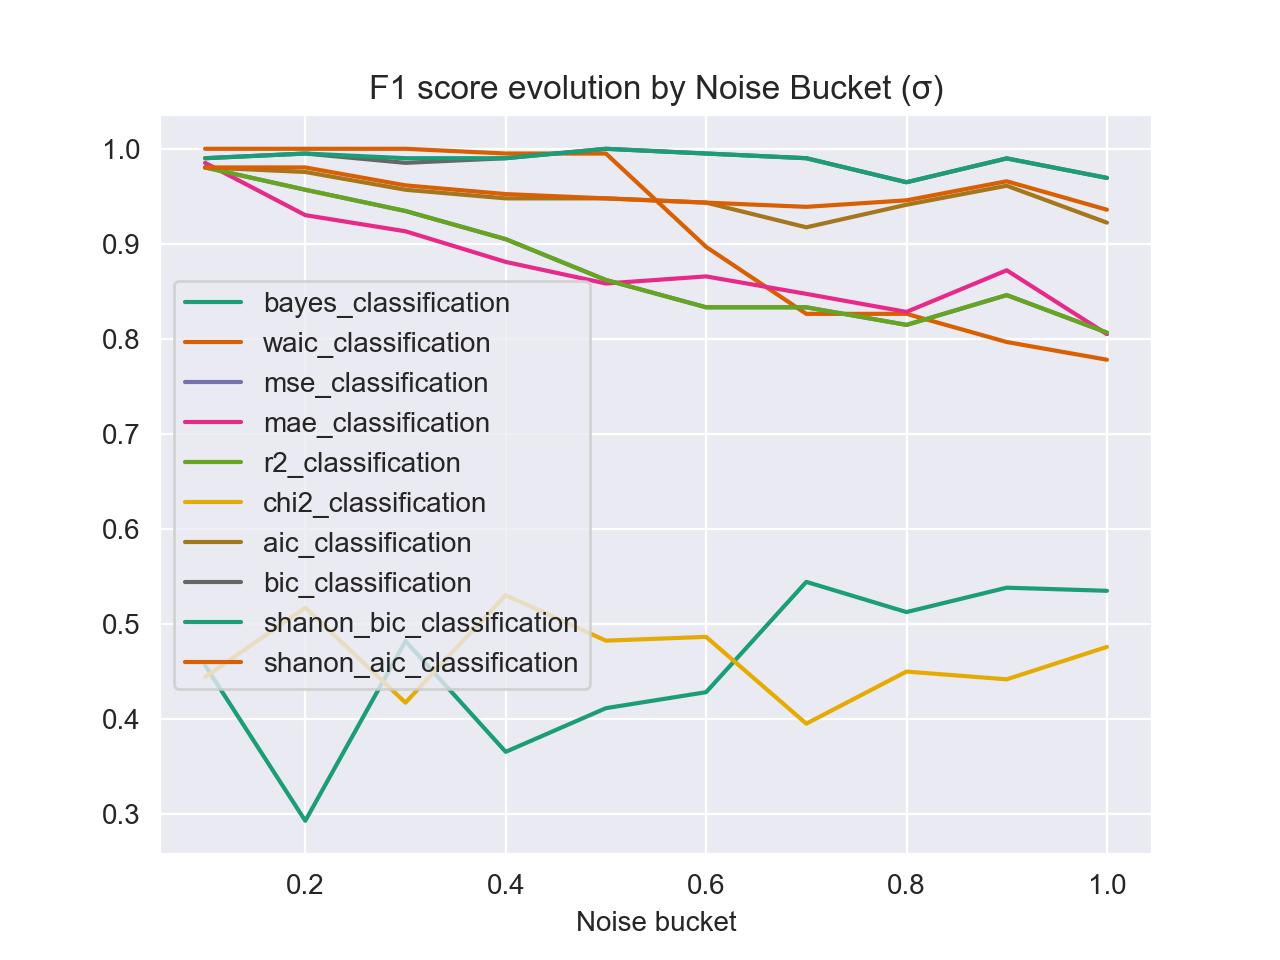

In [183]:
F1_no_drift = F1_df.loc[F1_df["drift"] == False]
for col in classification_col_list:
    plt.plot(F1_no_drift["noise_bucket"], F1_no_drift[col], label = col)
    plt.legend(loc='best')
    plt.xlabel("Noise bucket")
    plt.title("F1 score evolution by Noise Bucket (\u03C3)")
    